# The study for HMC BIW PROJECT  

## M/L is used to estimate the value with parameters.  
#


In [42]:
# import libraries
from __future__ import absolute_import, division, print_function, unicode_literals

# tensorflow libraries
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import tensorflow_docs as tfdocs
import tensorflow_docs.plots
import tensorflow_docs.modeling

# other utiles
import matplotlib.pyplot as plt
from  IPython import display
import numpy as np
import pandas as pd
import seaborn as sns
import pathlib

from numpy import shape, ravel, linspace, meshgrid, min, max, arange, array
from matplotlib import cm
from matplotlib import pyplot
import matplotlib.pyplot as plt
#from matplotlib.mlab import griddata
from mpl_toolkits.mplot3d import Axes3D
#from mpl_toolkits import natgrid
from scipy.interpolate import Rbf


# Pre-Checking Dataframe


In [43]:
#------------------------------------------------------
# read training dataset
#------------------------------------------------------
dir = r"F:\CON_2019_HMC_PGD-MINESET\0_MODEL\Zone\machineLearning\ITER_2000"
csv = dir+r"\training_data2.csv"
dataset = pd.read_csv(csv)
dataset.pop("Train")
dataset.head()



,p1,p2,p3,p4,p7,p8,p9,p10,Intrusion,Area
0,193.678511,50.974878,56.657004,127.193789,138.620307,42.077307,108.559538,110.427250,103.503174,2.809078
1,139.250786,80.555862,64.348697,37.767658,157.430219,165.159790,60.909341,70.166108,112.223633,2.810324
2,59.060636,169.646628,69.288772,68.998092,101.026681,147.962631,162.208917,36.224921,105.853577,2.792549
3,176.496336,177.758908,26.135000,182.826127,139.225299,108.033986,61.326045,111.138772,100.163086,2.793109
4,110.318064,198.036840,63.023811,142.524503,76.898240,90.950332,73.785577,95.766715,114.935242,2.803706


In [44]:
# extract the columns from the dataset
column_names = dataset.columns
print("parameters      : {}".format(column_names[0:8]))
# print("output_curves   : {}".format(column_names[9:30]))
# print("output_region   : {}".format(column_names[32]))
print("output_Area     : {}".format(column_names[9]))
print("output_Intrusion: {}".format(column_names[8]))



parameters      : Index(['p1', 'p2', 'p3', 'p4', 'p7', 'p8', 'p9', 'p10'], dtype='object')
output_Area     : Area
output_Intrusion: Intrusion


# SVR model

In [45]:
train_dataset = dataset.sample(frac=0.7)
test__dataset = dataset.drop(train_dataset.index)


In [46]:
# # make an instance for dataframe as "train_stats"
train_stats = train_dataset.describe()
# train_stats
column_names[8:10]

Index(['Intrusion', 'Area'], dtype='object')

In [47]:
# # delete "Area" column from "train_stats"
for col in column_names[8:10]:
    train_stats.pop(col)

train_stats   = train_stats.transpose()    
train_stats.head()


,count,mean,std,min,25%,50%,75%,max
p1,1400.0,113.401949,50.576536,25.050324,70.315747,113.205479,157.799316,199.999230
p2,1400.0,111.474601,50.522967,25.284001,67.294921,111.537751,155.381092,199.854130
p3,1400.0,112.470962,51.110854,25.228179,68.336716,113.215298,157.275046,199.913123
p4,1400.0,112.685389,50.361672,25.005029,69.120224,113.484653,156.585318,199.951722
p7,1400.0,115.056632,48.731135,30.115416,73.216050,115.137729,157.887364,199.986832


In [48]:
# Define functions

def norm(x, train_stats):
  stats=train_stats
  return (x - stats['mean']) / stats['std']

model = None
def build_model(iunit, ounit, train_dataset,activation="sigmoid",loss='binary_crossentropy',metrics=['accuracy']):
    model = keras.Sequential([
      layers.Dense(iunit, activation='relu', 
                   kernel_regularizer=keras.regularizers.l2(0.01), 
                   input_shape=[len(train_dataset.keys())]),
      layers.Dense(iunit, activation='relu', 
                   kernel_regularizer=keras.regularizers.l2(0.001)
                   ), 
      # layers.Dense(iunit, activation='relu', 
      #              kernel_regularizer=keras.regularizers.l2(0.001)
      #              ),                     
      # layers.Dense(iunit, activation='relu', 
      #              kernel_regularizer=keras.regularizers.l2(0.001)
      #              ),                    
      layers.Dense(ounit,activation=activation)
      ])
    # optimizer = tf.keras.optimizers.RMSprop(lr=0.01, rho=0.9, epsilon=None, decay=0.0)
    #optimizer = tf.keras.optimizers.Adagrad(lr=0.01, epsilon=None, decay=0.0)
    #optimizer = tf.keras.optimizers.SGD(lr=0.01, momentum=0.0, decay=0.0, nesterov=False)
    #optimizer = tf.keras.optimizers.Adadelta(lr=1.0, rho=0.95, epsilon=None, decay=0.0)
    optimizer = tf.keras.optimizers.Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0, amsgrad=False)
    # optimizer = tf.keras.optimizers.Adamax(lr=0.002, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0)
    #optimizer = tf.keras.optimizers.Nadam(lr=0.002, beta_1=0.9, beta_2=0.999, epsilon=None, schedule_decay=0.004)
    
    model.compile(
      loss=loss, #'mse', #'binary_crossentropy'
      optimizer=optimizer,
      # 'mae', 'mse', 'mape','accuracy'
      metrics=metrics)

    return model  

# Training
def training(EPOCHS=1000, model=model, normed_train_data=None, train_labels=None,verbose=0,monitor='accuracy',patience=5 ):
    model=model
    # history = model.fit(
    #                       normed_train_data, train_labels,
    #                       epochs=EPOCHS, validation_split = 0.2, verbose=verbose,
    #                       callbacks=[tfdocs.modeling.EpochDots()]
    #                       # callbacks=[keras.callbacks.TensorBoard(log_dir=dir+r'\logs')]
    #                       )
    print("% : Training : end", model) 
    early_stop = keras.callbacks.EarlyStopping(monitor=monitor, patience=patience) #loss,accuracy,val_loss,val_accuracy
    early_history = model.fit(normed_train_data, train_labels, 
                    epochs=EPOCHS, validation_split = 0.4, verbose=0, 
                    callbacks=[early_stop, tfdocs.modeling.EpochDots()]
                    # callbacks=[keras.callbacks.TensorBoard(log_dir=dir+r'\logs')]
                    )  

    return model, early_history   

In [49]:
# make instances for dataset without the QoI
train_labels_Intr   = train_dataset.loc[:,'Intrusion']
test__labels_Intr   = test__dataset.loc[:,'Intrusion']
train_labels_Area   = train_dataset.loc[:,'Area']
test__labels_Area   = test__dataset.loc[:,'Area']

for i in range(8,10):    
    train_dataset.pop(column_names[i])
    test__dataset.pop(column_names[i])
 
def norm(x, train_stats):
  stats=train_stats
  return (x - stats['mean']) / stats['std']
  
normed_train_data   = norm( train_dataset,  train_stats   )
normed_test__data   = norm( test__dataset,  train_stats   )


In [50]:
normed_test__data

,p1,p2,p3,p4,p7,p8,p9,p10
0,1.587229,-1.197470,-1.092018,0.288084,0.483545,-1.479817,-0.133612,-0.089019
4,-0.060975,1.713325,-0.967449,0.592497,-0.783039,-0.496262,-0.845260,-0.383223
6,0.742295,0.178529,0.135643,0.130975,1.433950,-1.601686,-0.277704,-1.386632
20,1.642663,-1.008918,1.463414,-0.176650,0.211769,-0.331990,-0.175514,-0.840558
24,1.156352,1.511597,-1.326780,1.128523,1.473976,-0.241476,-0.993018,0.105612
...,...,...,...,...,...,...,...,...
1985,-0.884667,1.269194,-0.311331,0.150416,-1.113204,0.347301,1.425025,0.544489
1986,0.064549,0.141438,-1.471438,-0.386837,0.443288,-0.294544,1.318110,-1.131758
1989,-0.863217,1.655164,0.184665,0.522760,-1.717926,-1.247310,1.175824,-1.469449
1992,0.862345,0.654835,0.397776,1.336230,0.257559,-0.261252,-0.587977,0.437343


## M/L for Intursion without classification

In [110]:
X_data = normed_train_data.values
Y_data = train_labels_Intr.values
# X_data = dataset.iloc[:,0:56].values
# Y_data = dataset.iloc[:,32].values

In [276]:
# from sklearn.svm import SVR

# regr = RandomForestRegressor(n_estimators=100, *, criterion='mse', max_depth=None, min_samples_split=2, min_samples_leaf=1, min_weight_fraction_leaf=0.0, max_features='auto', max_leaf_nodes=None, min_impurity_decrease=0.0, min_impurity_split=None, bootstrap=True, oob_score=False, n_jobs=None, random_state=None, verbose=0, warm_start=False, ccp_alpha=0.0, max_samples=None)

X_data = normed_train_data.values
Y_data = train_labels_Intr.values

# SVR
from sklearn.svm import SVR
svr = SVR(kernel='rbf', degree=1, gamma='scale', coef0=0., tol=0.001, C=5573.004848107421, epsilon=82.20276334182128, shrinking=True, cache_size=200, verbose=False, max_iter=-1)
y_rbf = svr.fit(X_data, Y_data).predict(X_data)
# C = 5573.004848107421 and epsilon = 82.20276334182128
# RandomForestRegressor
from sklearn.ensemble import RandomForestRegressor
regr = RandomForestRegressor(n_estimators=100, random_state=0, bootstrap=True, 
    criterion='mse', max_depth=None, max_leaf_nodes=None,
    min_samples_split=2, min_samples_leaf=1, 
    max_features='auto')
y_reg  = regr.fit(X_data, Y_data).predict(X_data)

# AdaBoostRegressor
# from sklearn.tree import DecisionTreeRegressor
# from sklearn.ensemble import AdaBoostRegressor
# adab = AdaBoostRegressor(DecisionTreeRegressor(max_depth=4),learning_rate=1.0,loss='linear', n_estimators=50, random_state=None)
# #      AdaBoostRegressor(base_estimator=None, *, n_estimators=50, learning_rate=1.0, loss='linear', random_state=None)
# y_ada = adab.fit(X_data, Y_data).predict(X_data)

#NN
# EPOCHS = 5000
# nPar = 8
# nOut = 1
# iunit = nPar * nOut
# ounit = nOut
# print("nPar: {}, nOut: {}, iunit: {}, ounit: {}".format(nPar,nOut,iunit,ounit))
# model_Intr = build_model(iunit, ounit, train_dataset,activation=None,loss='mape',metrics=['mape'])
# model_Intr, model_Intr_early_history = training(EPOCHS, model_Intr, normed_train_data, train_labels_Intr, verbose=0, monitor='mape', patience=5)


# model_Intr.save(dir+r'\trainingdata_Intr_for_Zone.h5')


In [277]:
y_nn = model_Intr.predict(normed_train_data).flatten()

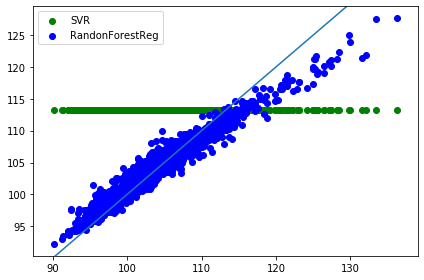

In [278]:
plt.scatter(Y_data, y_rbf, color='green', label='SVR'  )
plt.scatter(Y_data, y_reg, color='blue',  label='RandonForestReg'  )
# plt.scatter(Y_data, y_ada, color='red',   label='AdaBoostRegressor')
# plt.scatter(Y_data, y_nn , color='yellow',label='Neural network')
plt.legend()
plt.tight_layout()
plt.xlim([plt.xlim()[0],plt.xlim()[1]])
plt.ylim([plt.ylim()[0],plt.ylim()[1]])
_ = plt.plot([0, 150], [0, 150])
plt.show()
# print("time : ", time.time() - start_time)

In [279]:
X_data = normed_test__data.values
Y_data = test__labels_Intr.values
# X_data
y_rbf =  svr.predict(X_data)
y_reg = regr.predict(X_data)
y_ada = adab.predict(X_data)
y_nn  = model_Intr.predict(X_data).flatten()

In [280]:
# print("{},{},{}".format(size(y_rbf),len(y_regr),len(y_adab)))
# Y_data.size

600,600


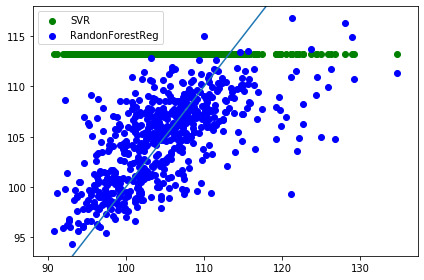

In [281]:
print("{},{}".format(Y_data.size,y_rbf.size))
plt.scatter(Y_data, y_rbf, color='green', label='SVR'  )
plt.scatter(Y_data, y_reg, color='blue',  label='RandonForestReg'  )
# plt.scatter(Y_data, y_ada, color='red',   label='AdaBoostRegressor')
# plt.scatter(Y_data, y_nn , color='yellow',label='Neural network')
plt.legend()
plt.tight_layout()
plt.xlim([plt.xlim()[0],plt.xlim()[1]])
plt.ylim([plt.ylim()[0],plt.ylim()[1]])
_ = plt.plot([0, 150], [0, 150])
plt.show()

In [58]:
# # create the model instance 
EPOCHS = 5000
nPar = 64
nOut = 1
iunit = nPar * nOut
ounit = nOut
print("nPar: {}, nOut: {}, iunit: {}, ounit: {}".format(nPar,nOut,iunit,ounit))
model_Intr = build_model(iunit, ounit, train_dataset,activation=None,loss='mse',metrics=['mse'])
model_Intr, model_Intr_history, model_Intr_early_history = training(EPOCHS, model_Intr, normed_train_data, train_labels_Intr, verbose=0, monitor='mse', patience=5)


model_Intr.save(dir+r'\trainingdata_Intr_for_Zone.h5')

nPar: 64, nOut: 1, iunit: 64, ounit: 1
% : Training : end <tensorflow.python.keras.engine.sequential.Sequential object at 0x00000254C2575048>

Epoch: 0, loss:10795.3121,  mse:10795.1045,  val_loss:10487.9866,  val_mse:10487.7686,  
....................................................................................................
Epoch: 100, loss:40.2337,  mse:39.8651,  val_loss:39.9184,  val_mse:39.5504,  
................................................................................

ValueError: not enough values to unpack (expected 3, got 2)

In [ ]:
test_mae_score_Intr, test_mae_score1_Intr = model_Intr.evaluate(  normed_test__data, test__labels_Intr  )
print(test_mae_score_Intr, test_mae_score1_Intr)

In [ ]:
train_predictions = model_Intr.predict(normed_train_data).flatten()
test__predictions = model_Intr.predict(normed_test__data).flatten()
print("{},{}".format(len(train_predictions),len(train_labels_Intr)))
plt.scatter(train_labels_Intr, train_predictions)
plt.scatter(test__labels_Intr, test__predictions )

plt.xlabel('True Values [Intr]')
plt.ylabel('Predictions [Intr]')
plt.axis('equal')
plt.axis('square')
plt.xlim([90,plt.xlim()[1]])
plt.ylim([90,plt.ylim()[1]])
_ = plt.plot([0, 150], [0, 150])

In [ ]:
# train_predictions = np.array(train_value)  
# test_predictions  = np.array(test__value) 
# print("size:  {},{}".format(len(test_predictions),len(test_labels__Intr)))
# print("type:  {},{}".format(type(test_predictions),type(test_labels__Intr)))
# print("dtype: {},{}".format(test_labels__Intr.dtype,  test_predictions.dtype))
# print("ndim:  {},{}".format(test_labels__Intr.ndim,   test_predictions.ndim))
# print("size:  {},{}".format(test_labels__Intr.size,   test_predictions.size))
# print("nbytes:{},{}".format(test_labels__Intr.nbytes, test_predictions.nbytes))
# data = test__labels_Intr.iloc[0]
# print(type(data))
error = test__predictions - test__labels_Intr

plt.hist(error, bins = 25)
plt.xlabel("Prediction Error [Intrusion]")
_ = plt.ylabel("Count")

In [ ]:
# 모델 학습 과정 표시하기
%matplotlib inline
import matplotlib.pyplot as plt

fig, loss_ax = plt.subplots()
# acc_ax = loss_ax.twinx()

hist = model_Intr_history
# hist = model_Intr_early_history 
loss_ax.plot(hist.history['loss'], 'y', label='train loss')
loss_ax.plot(hist.history['val_loss'], 'r', label='val loss')

# acc_ax.plot(hist.history['mse'], 'b', label='train mse')
# acc_ax.plot(hist.history['val_mse'], 'g', label='val mse')

loss_ax.set_xlabel('epoch')
loss_ax.set_ylabel('loss')
# acc_ax.set_ylabel('mse')

loss_ax.legend(loc='upper left')
# acc_ax.legend(loc='lower left')

plt.show()

In [ ]:
# train_dataset.to_csv(r"F:\CON_2019_HMC_PGD-MINESET\Zone5_mat590\DROP_SIMUL_200\train_dataset_intr_2.csv")
# test_dataset.to_csv(r"F:\CON_2019_HMC_PGD-MINESET\Zone5_mat590\DROP_SIMUL_200\test_dataset_intr_2.csv")

pd.DataFrame(train_predictions).to_csv(dir+r"\train_pred_intr.csv")
pd.DataFrame(test__predictions).to_csv(dir+r"\test__pred_intr.csv")

In [ ]:
plotter = tfdocs.plots.HistoryPlotter(smoothing_std=2)
plotter.plot({'Basic': model_Intr_history}, metric = "mse")
plt.ylim([-1, 5])
plt.ylabel('MSE_Intr')

## M/L for Intursion of region_2

In [ ]:
# # # create the model for intusion by region_2
# EPOCHS = 5000
# nPar = 64
# nOut = 1
# iunit = nPar * nOut
# ounit = nOut
# print("nPar: {}, nOut: {}, iunit: {}, ounit: {}".format(nPar,nOut,iunit,ounit))
# model_Intr_2 = build_model(iunit, ounit, train_dataset_2, activation=None,loss='mse',metrics=['mse'])
# model_Intr_2, model_Intr_2_history, model_Intr_2_early_history = training(EPOCHS, model_Intr_2, normed_train_data_2, train_labels_Intr_2, verbose=0, monitor='mse', patience=5)

# model_Intr_2.save(dir+r'\trainingdata_Intr_for_Zone_2.h5')

In [ ]:
# test_mae_score_Intr_2, test_mae_score1_Intr_2 = model_Intr_2.evaluate(  normed_test__data_2, test__labels_Intr_2  )
# print(test_mae_score_Intr_2, test_mae_score1_Intr_2)

In [ ]:
# train_predictions = model_Intr_2.predict(normed_train_data_2).flatten()
# test__predictions = model_Intr_2.predict(normed_test__data_2).flatten()

# plt.scatter(train_labels_Intr_2, train_predictions)
# plt.scatter(test__labels_Intr_2, test__predictions)

# plt.xlabel('True Values [Intr_2]')
# plt.ylabel('Predictions [Intr_2]')
# plt.axis('equal')
# plt.axis('square')
# plt.xlim([90,plt.xlim()[1]])
# plt.ylim([90,plt.ylim()[1]])
# _ = plt.plot([90, 150], [90, 150])

In [ ]:
# error = test__predictions - test__labels_Intr_2

# plt.hist(error, bins = 25)
# plt.xlabel("Prediction Error [Intrusion_region2]")
# _ = plt.ylabel("Count")

In [ ]:
# train_dataset_2.to_csv(dir+r"\train_dataset_intr_2.csv")
# test__dataset_2.to_csv(dir+r"\test__dataset_intr_2.csv")

# pd.DataFrame(train_predictions).to_csv(dir+r"\train_pred_intr_2.csv")
# pd.DataFrame(test__predictions).to_csv(dir+r"\test__pred_intr_2.csv")

In [ ]:
# plotter = tfdocs.plots.HistoryPlotter(smoothing_std=2)
# plotter.plot({'Basic': model_Intr_2_history}, metric = "mse")
# plt.ylim([-1, 2000])
# plt.ylabel('MSE_Intr_2')

## M/L for Intursion of region_3

In [ ]:
# # # create the model for intusion by region_3
# EPOCHS = 5000
# nPar = 64
# nOut = 1
# iunit = nPar * nOut
# ounit = nOut
# print("nPar: {}, nOut: {}, iunit: {}, ounit: {}".format(nPar,nOut,iunit,ounit))
# model_Intr_3 = build_model(iunit, ounit, train_dataset_3, activation=None,loss='mse',metrics=['mse'])
# model_Intr_3, model_Intr_3_history, model_Intr_3_early_history = training(EPOCHS, model_Intr_3, normed_train_data_3, train_labels_Intr_3, verbose=0, monitor='mse', patience=5)

# model_Intr_3.save(dir+r'\trainingdata_Intr_for_Zone_3.h5')

In [ ]:
# plotter = tfdocs.plots.HistoryPlotter(smoothing_std=2)
# plotter.plot({'Basic': model_Intr_3_history}, metric = "mse")
# plt.ylim([-1, 500])
# plt.ylabel('MSE_Intr_3')

In [ ]:
# test_mae_score_Intr_3, test_mae_score1_Intr_3 = model_Intr_3.evaluate(  normed_test__data_3, test__labels_Intr_3  )
# print(test_mae_score_Intr_3, test_mae_score1_Intr_3)

In [ ]:
# train_predictions = model_Intr_3.predict(normed_train_data_3).flatten()
# test__predictions = model_Intr_3.predict(normed_test__data_3).flatten()

# plt.scatter(train_labels_Intr_3, train_predictions)
# plt.scatter(test__labels_Intr_3, test__predictions)

# plt.xlabel('True Values [Intr_3]')
# plt.ylabel('Predictions [Intr_3]')
# plt.axis('equal')
# plt.axis('square')
# plt.xlim([90,plt.xlim()[1]])
# plt.ylim([90,plt.ylim()[1]])
# _ = plt.plot([90, 150], [90, 150])

In [ ]:
# error = test__predictions - test__labels_Intr_3

# plt.hist(error, bins = 25)
# plt.xlabel("Prediction Error [Intrusion_region3]")
# _ = plt.ylabel("Count")

In [ ]:
# train_dataset_3.to_csv(dir+r"\train_dataset_intr_3.csv")
# test__dataset_3.to_csv(dir+r"\test__dataset_intr_3.csv")

# pd.DataFrame(train_predictions).to_csv(dir+r"\train_pred_intr_3.csv")
# pd.DataFrame(test__predictions).to_csv(dir+r"\test__pred_intr_3.csv")

## M/L for Area reduction

In [41]:
# AdaBoostRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import AdaBoostRegressor
adab_area = AdaBoostRegressor(DecisionTreeRegressor(max_depth=4),learning_rate=1.0,loss='linear', n_estimators=50, random_state=None)
#      AdaBoostRegressor(base_estimator=None, *, n_estimators=50, learning_rate=1.0, loss='linear', random_state=None)
y_adab_area = adab_area.fit(X_data, Y_data).predict(X_data)

EPOCHS = 5000
nPar = 64
nOut = 1
iunit = nPar * nOut
ounit = nOut
print("nPar: {}, nOut: {}, iunit: {}, ounit: {}".format(nPar,nOut,iunit,ounit))
model_Area = build_model(iunit, ounit, train_dataset, activation=None,loss='mse',metrics=['mse'])
model_Area, model_Area_history, model_Area_early_history = training(EPOCHS, model_Area, normed_train_data, train_labels_Area, verbose=0, monitor='mse', patience=5)
model_Area.save(dir+r'\trainingdata_Area_for_Zone.h5')

nPar: 64, nOut: 1, iunit: 64, ounit: 1
% : Training : end <tensorflow.python.keras.engine.sequential.Sequential object at 0x00000254C4D71348>

Epoch: 0, loss:4.4732,  mse:4.2629,  val_loss:1.2785,  val_mse:1.0624,  
..........................................................................................

ValueError: not enough values to unpack (expected 3, got 2)

In [ ]:
test_mae_score_Area, test_mae_score1_Area = model_Area.evaluate(  normed_test__data, test__labels_Area  )
print(test_mae_score_Area, test_mae_score1_Area)

In [ ]:
train_predictions = model_Area.predict(normed_train_data).flatten()
test__predictions = model_Area.predict(normed_test__data).flatten()

plt.scatter(train_labels_Area, train_predictions)
plt.scatter(test__labels_Area, test__predictions )

plt.xlabel('True Values [Area]')
plt.ylabel('Predictions [Area]')
plt.axis('equal')
plt.axis('square')
plt.xlim([-1000,plt.xlim()[1]])
plt.ylim([-1000,plt.ylim()[1]])
_ = plt.plot([-1000, 10000], [-1000, 10000])

In [ ]:
error = test__predictions - test__labels_Area

plt.hist(error, bins = 25)
plt.xlabel("Prediction Error [Intrusion_Area]")
_ = plt.ylabel("Count")

In [ ]:
# train_dataset.to_csv(r"F:\CON_2019_HMC_PGD-MINESET\Zone5_mat590\DROP_SIMUL_200\train_dataset.csv")
# test_dataset.to_csv(r"F:\CON_2019_HMC_PGD-MINESET\Zone5_mat590\DROP_SIMUL_200\test_dataset.csv")

pd.DataFrame(train_predictions).to_csv(dir+r"\train_pred_area.csv")
pd.DataFrame(test__predictions).to_csv(dir+r"\test__pred_area.csv")

In [ ]:
plotter = tfdocs.plots.HistoryPlotter(smoothing_std=2)
plotter.plot({'Basic': model_Area_history}, metric = "mse")
plt.ylim([-0.1, 1000])
plt.ylabel('MSE_Area')

In [ ]:
# plotter = tfdocs.plots.HistoryPlotter(smoothing_std=2)
# plotter.plot({'Early Stopping': early_history}, metric = "mae")
# plt.ylim([-1, 10])
# plt.ylabel('MAE')

In [ ]:
# study for dataframe
# data = {'a':[1,2,3.0],'b':[0.1,0.2,0.3],'sub':['1st','2nd','3nd']}
# df = pd.DataFrame(data)
# df
# df = pd.DataFrame(data, columns=['sub','a','b'])
# df
# df = df.reindex(index = [0,2,1])
# df
# df['c']=np.nan
# df
# df.loc[:,['c']]=[1,2,3]
# df

In [ ]:
# model evaluate by curve
# model = keras.models.load_model(r'F:\CON_2019_HMC_PGD-MINESET\Zone5_mat590\machineLearning\trainingdata_for_Zone.h5')
# test_predictions = model.predict(normed_test_data).flatten()
# test_predictions = model.predict(normed_test_data)
# print("normed_test_data: {}".format(normed_test_data))
# print("test_dataset    : {}".format(test_dataset))
# print("test_predictions: {}".format(test_predictions))


# Optimization

In [ ]:
import pandas as pd
import numpy as np
import os
from tensorflow.keras.models import Sequential, load_model
from scipy import optimize
import time


In [ ]:
# # Number of Curve points
# point = 39
# # Number of variables 
# var = 8

In [ ]:
# predict_func
# Mean square error between test and prediction

def predict_func( lst ):
    import math
    # # Result of prediction data 
    reg = 0 
    
    lstVar  = [ var  for var  in lst    ]

    for i in range( 0, len(lstVar) ):
        if lstVar[i] <= 515 :
            lstVar[i] = 440
        elif 515 < lstVar[i] <= 685:
            lstVar[i] = 590
        elif 685 < lstVar[i] <= 880:
            lstVar[i] = 780
        elif 880 < lstVar[i] <= 1080:
            lstVar[i] = 980
        elif 1080 < lstVar[i] <= 1290:
            lstVar[i] = 1180
        elif 1290 < lstVar[i] :
            lstVar[i] = 1400


    lstVarN = [ norm(varN, train_stats) for varN in lstVar ]

    # predict_Reg  = model_Reg.predict( [lstVarN] )[0]
    predict_Intr = model_Intr.predict( [lstVarN] )[0]

    # predict_Intr_2 = model_Intr_2.predict( [lstVarN] )[0]
    # predict_Intr_3 = model_Intr_3.predict( [lstVarN] )[0]

    predict_Area = model_Area.predict( [lstVarN] )[0]

    # cVal = 0
    # sInt = 0 
    # sAre = 0
    # sReg = 0

    # for i in range(0,len(predict)):
    #     if i <= 20: # curve data
    #         cVal = cVal + predict[i]
    #     if i == 21: # max. intrusion
    #         sInt = predict[i]
    #     if i == 22: # area
    #         sAre = predict[i]
    #     if i == 23: # region
    #         sReg = predict[i]

    # lst_max = (dataset.max(0))
    # lst_min = (dataset.min(0))
    # print("max={}, min={} of first Column".format(lst_max[1],lst_min[1] ))

    # if predict_Reg[0] > predict_Reg[1] :
    #     predict_Intr = predict_Intr_2
    #     reg = 0
    # else:
    #     predict_Intr = predict_Intr_3
    #     reg = 1
    

    # if predict_Reg < 2.5:
    #     predict_Intr = predict_Intr_2
    # else:
    #     predict_Intr = predict_Intr_3

    norm_Int  = math.sqrt( ((predict_Intr - lst_min[57])/(lst_max[57] - lst_min[57]))**2 ) 
    # norm_Int_2  = math.sqrt( ((predict_Intr_2 - lst_min[29])/(lst_max[29] - lst_min[29]))**2 ) 
    # norm_Int_3  = math.sqrt( ((predict_Intr_3 - lst_min[29])/(lst_max[29] - lst_min[29]))**2 ) 

    norm_Area = math.sqrt( ((predict_Area - lst_min[56])/(lst_max[56] - lst_min[56]))**2 ) 


    # print("min: {}, max: {}".format(lst_min[30], lst_max[30]))
    print("parameter: {}".format(lstVar))
    print("Region: {}, Intursion: {}, Area: {}".format(reg, predict_Intr, predict_Area))

    # weight1 = 0.2


    return  norm_Int + norm_Area


In [ ]:
# normed_train_data_3

In [ ]:
# 1st
bnds = [( 440, 1400 ), ( 440, 1400 ), ( 440, 1400 ), ( 440, 1400 ), ( 440, 1400 ), 
        ( 440, 1400 ), ( 440, 1400 ), ( 440, 1400 ), ( 440, 1400 ), ( 440, 1400 ), 
        ( 440, 1400 ), ( 440, 1400 ), ( 440, 1400 ), ( 440, 1400 ), ( 440, 1400 ), 
        ( 440, 1400 ), ( 440, 1400 ), ( 440, 1400 ), ( 440, 1400 ), ( 440, 1400 ), 
        ( 440, 1400 ), ( 440, 1400 ), ( 440, 1400 ), ( 440, 1400 ), ( 440, 1400 ), 
        ( 440, 1400 ), ( 440, 1400 ), ( 440, 1400 ), ( 440, 1400 ), ( 440, 1400 ), 
        ( 440, 1400 ), ( 440, 1400 ), ( 440, 1400 ), ( 440, 1400 ), ( 440, 1400 ), 
        ( 440, 1400 ), ( 440, 1400 ), ( 440, 1400 ), ( 440, 1400 ), ( 440, 1400 ),                       
        ( 440, 1400 ), ( 440, 1400 ), ( 440, 1400 ), ( 440, 1400 ), ( 440, 1400 ), 
        ( 440, 1400 ), ( 440, 1400 ), ( 440, 1400 ), ( 440, 1400 ), ( 440, 1400 ),
        ( 440, 1400 ), ( 440, 1400 ), ( 440, 1400 ), ( 440, 1400 ), ( 440, 1400 ),
        ( 440, 1400 )]
from scipy import optimize
# best1bin
result_best1bin = optimize.differential_evolution(predict_func, bnds, strategy='best1bin', init='latinhypercube')
print("DONE!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!")


In [ ]:
# Get minimize parameters
minimum_best1bin_x = result_best1bin.x
minimum_best1bin_f = result_best1bin.fun
minimum_best1bin_x, minimum_best1bin_f

In [ ]:
for i in range( 0, len(minimum_best1bin_x) ):
    if minimum_best1bin_x[i] <= 515 :
        minimum_best1bin_x[i] = 440
    elif 515 < minimum_best1bin_x[i] <= 685:
        minimum_best1bin_x[i] = 590
    elif 685 < minimum_best1bin_x[i] <= 880:
        minimum_best1bin_x[i] = 780
    elif 880 < minimum_best1bin_x[i] <= 1080:
        minimum_best1bin_x[i] = 980
    elif 1080 < minimum_best1bin_x[i] <= 1290:
        minimum_best1bin_x[i] = 1180
    elif 1290 < minimum_best1bin_x[i] :
        minimum_best1bin_x[i] = 1400
minimum_best1bin_x   

In [ ]:
for i in range( 0, len(minimum_best1bin_x) ):
    if minimum_best1bin_x[i] <= 515 : 
        minimum_best1bin_x[i] = 11380000
    elif 515 < minimum_best1bin_x[i] <= 685:
        minimum_best1bin_x[i] = 11130000
    elif 685 < minimum_best1bin_x[i] <= 880:
        minimum_best1bin_x[i] = 11160000
    elif 880 < minimum_best1bin_x[i] <= 1080:
        minimum_best1bin_x[i] = 11190000
    elif 1080 < minimum_best1bin_x[i] <= 1290:
        minimum_best1bin_x[i] = 11210000
    elif 1290 < minimum_best1bin_x[i] :
        minimum_best1bin_x[i] = 60101030
minimum_best1bin_x        

In [ ]:
#Second
bnds = [( 25, 200 ), ( 25, 200 ), ( 25, 200 ), ( 25, 200 ),
        ( 30, 200 ), ( 30, 200 ), ( 30, 200 ), ( 30, 200 )
]
from scipy import optimize
# best1bin
result_best1bin = optimize.differential_evolution(predict_func, bnds, strategy='best1bin', init='latinhypercube')
print("DONE!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!")

In [ ]:
# 2nd: Get minimize parameters
minimum_best1bin_x = result_best1bin.x
minimum_best1bin_f = result_best1bin.fun
minimum_best1bin_x, minimum_best1bin_f

In [ ]:
#Third
bnds = [( 25, 200 ), ( 25, 200 ), ( 25, 200 ), ( 25, 200 ),
        ( 30, 200 ), ( 30, 200 ), ( 30, 200 ), ( 30, 200 )
]
from scipy import optimize
# best1bin
result_best1bin = optimize.differential_evolution(predict_func, bnds, strategy='best1bin', init='latinhypercube')
print("DONE!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!")

In [ ]:
# 3nd: Get minimize parameters
minimum_best1bin_x = result_best1bin.x
minimum_best1bin_f = result_best1bin.fun
minimum_best1bin_x, minimum_best1bin_f

In [ ]:
# normed_test_data

# test_predictions = model.predict(normed_test_data)
# print("normed_test_data: {}".format(normed_test_data))
# print("test_dataset    : {}".format(test_dataset))
# print("test_predictions: {}".format(test_predictions))